In [ ]:
import pm4py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.conversion.process_tree import converter as process_tree_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

In [2]:
log = pm4py.read_xes('../data/BPI Challenge 2017.xes/BPI Challenge 2017.xes', return_legacy_log_object=True)

c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:41<00:00, 311.66it/s]


In [31]:
# retain only cases with a final decision by the bank

allowed_events = ["A_Pending", "A_Cancelled", "A_Denied"]

pruned_log = pm4py.filter_event_attribute_values(
    log,
    attribute_key="concept:name",
    values=allowed_events,
    level="case",
    retain=True
)

perc = 0.003
filtered_log = pm4py.filter_variants_by_coverage_percentage(pruned_log, perc)


In [40]:
thresholds = [1.0, 0.8, 0.5, 0.3, 0.1]  

for t in thresholds:
    perc = t / 100.0

    test_log = pm4py.filter_variants_by_coverage_percentage(pruned_log, perc)

    cases_retained = len(test_log)
    variants_retained = len(pm4py.get_variants(test_log))

    print(f"{t:<23} {cases_retained:<15} {variants_retained}")

1.0                     3594            5
0.8                     4170            7
0.5                     5000            11
0.3                     6272            21
0.1                     8861            68


# Mining

## Inductive Miner

In [32]:
process_tree = inductive_miner.apply(filtered_log)
ind_net, ind_im, ind_fm = process_tree_converter.apply(process_tree)

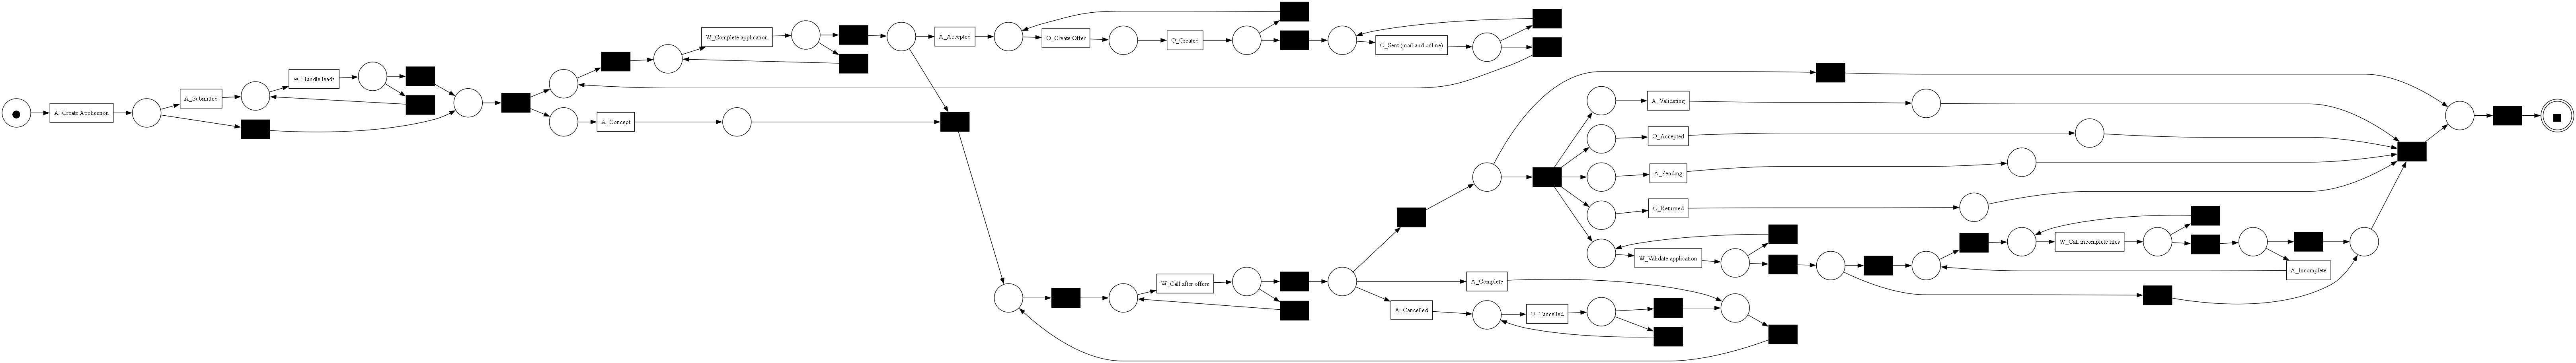

In [33]:
gviz = pn_visualizer.apply(ind_net, ind_im, ind_fm)
pn_visualizer.view(gviz=gviz)


## Heuristic Miner

In [34]:
heu_net, heu_im, heu_fm = heuristics_miner.apply(filtered_log)

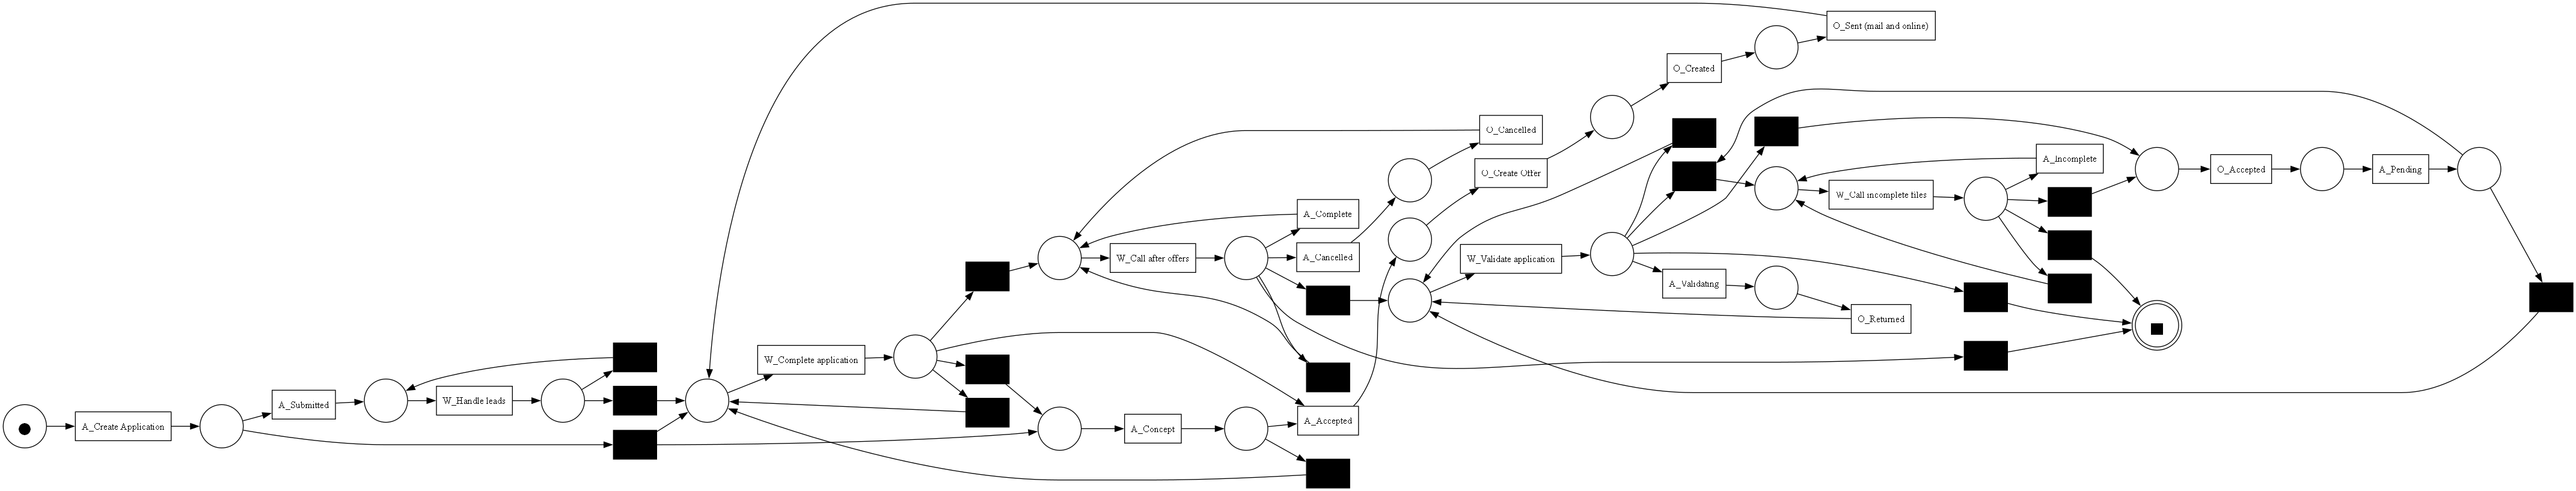

In [35]:
heu_gviz = pn_vis.apply(heu_net, heu_im, heu_fm)
pn_vis.view(heu_gviz)

# Evaluating the nets


1. Custom BPMN 
2. Heuristic mined net
3. Inductive mined net

In [36]:

bpmn_graph = pm4py.read_bpmn("Final Draft.bpmn")
cust_net, cust_im, cust_fm = pm4py.convert_to_petri_net(bpmn_graph)

In [37]:
def eval_and_print(name, net, im, fm, log):
    print(f"\nEvaluation: {name}")
    metrics = general_evaluation.apply(log, net, im, fm)
    for k, v in metrics.items():
        print(f"{k}: {v}")
    return metrics

In [38]:
metrics_heuristics = eval_and_print("Heuristics Miner net", heu_net, heu_im, heu_fm, pruned_log)
metrics_inductive  = eval_and_print("Inductive Miner net", ind_net, ind_im, ind_fm, pruned_log)
metrics_custom     = eval_and_print("Custom BPMN Final Draft net", cust_net, cust_im, cust_fm, pruned_log)


Evaluation: Heuristics Miner net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [04:35<00:00, 954.45it/s] 


fitness: {'perc_fit_traces': 6.707841202126644, 'average_trace_fitness': 0.9668480806822735, 'log_fitness': 0.9642696450192514, 'percentage_of_fitting_traces': 6.707841202126644}
precision: 0.611482421982624
generalization: 0.9934955410374552
simplicity: 0.6288659793814432
metricsAverageWeight: 0.7995283968551935
fscore: 0.7483841529747398

Evaluation: Inductive Miner net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [11:25<00:00, 383.51it/s] 


fitness: {'perc_fit_traces': 39.87138263665595, 'average_trace_fitness': 0.9797227428041455, 'log_fitness': 0.9765972003664549, 'percentage_of_fitting_traces': 39.87138263665595}
precision: 0.4125977000403881
generalization: 0.9936086820110435
simplicity: 0.7099236641221374
metricsAverageWeight: 0.773181811635006
fscore: 0.580108318305912

Evaluation: Custom BPMN Final Draft net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [07:44<00:00, 566.82it/s] 


fitness: {'perc_fit_traces': 31.85826621247334, 'average_trace_fitness': 0.9798472424002788, 'log_fitness': 0.978021621907425, 'percentage_of_fitting_traces': 31.85826621247334}
precision: 0.5289604341044398
generalization: 0.9714360701161516
simplicity: 0.663716814159292
metricsAverageWeight: 0.7855337350718271
fscore: 0.6865838111659729


# Custom simplicity measures:

In [39]:
def avg_edges(name, net):
    places = len(net.places)
    arcs = len(net.arcs)
    print(f"{name}: places={places}, arcs={arcs}, avg={arcs/places:.3f}")

avg_edges("Heuristics Miner", heu_net)
avg_edges("Inductive Miner", ind_net)
avg_edges("Custom BPMN Final Draft", cust_net)



Heuristics Miner: places=23, arcs=79, avg=3.435
Inductive Miner: places=42, arcs=112, avg=2.667
Custom BPMN Final Draft: places=28, arcs=94, avg=3.357
